<a href="https://colab.research.google.com/github/srinivasrdhkrshnn/CS6910_Assignment_1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 


     |████████████████████████████████| 2.0MB 5.2MB/s 
     |████████████████████████████████| 133kB 22.7MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 163kB 22.1MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=29e6d3c3374a8373ff14cfb5a76b11ce548d80a3c3647a44a380f1dee40a9c25
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=5a0b53998c0445a363acd5616eb1bb62cbe1084a195914e70609cb9ba28278fb
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
4423680/4422102 [==============================] - 0s 0us/step


Sample Images for each Class :


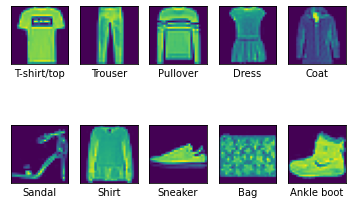

In [ ]:

print("Sample Images for each Class :")

for i in range(10):
  plt.subplot(2,5,i+1)
  for j in range(len(y_train)):
    if y_train[j] == i :
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_train[j])
      plt.xlabel(class_type[y_train[j]])
      break      
plt.show()

In [108]:
def activate(x,activation):                                 # Hidden layer activation function                                  

  if activation == "sigmoid":
    return 1/(1 + np.exp(-x))

  elif activation == "tanh": 
    return np.tanh(x) 

  elif activation == "relu": 
    return x * (x > 0) 

def softmax(x):                                                      # Output activation function
    return np.exp(x) / np.sum(np.exp(x), axis=0) 

def feed_forward(x,parameters,input_size,output_size):                                # feed-forward data through the network to estimate output
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)
  
  H_old = x
  H = {}
  A={}
  H[0] = x

  for i in range(1,len(sizes)-1):
    W = parameters["W"+str(i)]
    b = parameters["b"+str(i)]
    A[i] = np.dot(W,H_old)+b
    H[i] = activate(A[i],activation)
    H_old = H[i]

  W = parameters["W"+str(len(sizes)-1)]
  b = parameters["b"+str(len(sizes)-1)]
  A[len(sizes)-1] = np.dot(W,H_old)+b
  #print((A[1],H[1]))
  y_hat = softmax(A[len(sizes)-1])

  return y_hat,A,H

def loss_compute(y,y_hat,parameters,loss):                                # function to compute the loss/error (both squared error and cross entropy)

  if (loss == "squared_error"):
    error = np.sum((y-y_hat)**2)/(2*len(y))
  elif (loss == "cross_entropy") :
    error = -1*np.sum(np.multiply(y,np.log(y_hat)))/len(y)
		
  L = int(len(parameters)/2)
  reg_error = 0.0                                                    # account for regularization to avoid overfit of data - L2 norm regularization
  for i in range(1,L+1) :
    reg_error = reg_error + (reg/(2*len(y)))*np.sum(np.square(parameters["W"+str(i)])) 
  error = error + reg_error

  return error



In [106]:
def derivative(x,activation):                                        # function to compute the derivative of hidden layer activation fn

  if activation == "sigmoid":
    return activate(x,"sigmoid")*(1-activate(x,"sigmoid"))
  elif activation == "tanh": 
    return 1. - x * x 
  elif activation == "relu": 
    return 1. * (x > 0)

def grad_init(input_size,output_size):
  
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)
  grads={}
  layers=len(sizes)
  for i in range(1,layers):
    grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
    grads["db" + str(i)] = np.zeros((sizes[i],1))

  return grads  


def back_prop(x,Y,Y_hat,prev_grad,A,H,parameters,input_size,output_size) :     # back-propogation rule to compute the gradients of activation, pre-activation and parameters
  
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)

  layers = len(sizes)
  new_grad = {}
  grads = {"dH0":np.zeros((input_size,1)),"dA0":np.zeros((input_size,1))}
  #for i in range(1,layers):
    #grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
   # grads["db" + str(i)] = np.zeros((sizes[i],1))
    #grads["dA" + str(i)] = np.zeros((sizes[i],1))
    #grads["dH" + str(i)] = np.zeros((sizes[i],1))

  if loss == "squared_error":
    grads["dH"+str(layers-1)] = (Y_hat-Y)
    grads["dA"+str(layers-1)] = (Y_hat - Y)*Y_hat - Y_hat*(np.dot(np.transpose((Y_hat-Y)), Y_hat))

  elif loss=="cross_entropy" :
    grads["dH"+str(layers-1)] = -(Y/Y_hat)
    grads["dA"+str(layers-1)] = -(Y-Y_hat)

  for i in np.arange(layers-1, 0, -1):
    grads["dW" + str(i)] = np.dot(grads["dA" + str(i)], np.transpose(H[i-1]))
    grads["db" + str(i)] = grads["dA" + str(i)]
    grads["dH" + str(i-1)] = np.dot(np.transpose(parameters["W" + str(i)]), grads["dA" + str(i)])
    if i>1:
      grads["dA" + str(i-1)] = np.multiply((grads["dH" + str(i-1)]),derivative(A[i-1],activation))
  
  for i in range(1,n_hiddenlayer+1):
    new_grad["dW" + str(i)] = grads["dW" + str(i)] + prev_grad["dW" + str(i)]
    new_grad["db" + str(i)] = grads["db" + str(i)] + prev_grad["db" + str(i)]
    
  return new_grad  

In [92]:
# Initializations

# Data
X_train = np.array(x_train.reshape(x_train.shape[0], 784,1))         # reshape 2-D data to 1-D
X_test = np.array(x_test.reshape(x_test.shape[0], 784,1))            # reshape 2-D data to 1-D

def normalize_data(x):                                               # normalize input data
  x_norm = x.astype('float32')
  x_norm = x_norm / 255.0  
  return x_norm 

X_train = normalize_data(X_train)
X_val = X_train[-6000:]                                             # validation set input
X_train = X_train[0:54000]                                          # training set input
X_test = normalize_data(X_test)                                     # test set input


Y_train = np.zeros([len(y_train),10,1])
Y_test = np.zeros([len(y_test),10,1])

for i in range(len(y_train)):                                        # convert y from just a class number to an indicator vector (10x1)
  y = np.zeros([10, 1])
  y[y_train[i]] = 1.0
  Y_train[i] = y

Y_val = Y_train[-6000:]                                              # validation set output
Y_train = Y_train[0:54000]                                           # training set output

for i in range(len(y_test)):                                         # convert y from just a class number to an indicator vector (10x1)
  y = np.zeros([10, 1])
  y[y_test[i]] = 1.0
  Y_test[i] = y                                                      # test set output

input_size = 784                                                     # length of input
output_size = 10                                                     # length of output

# hyperparameters
n_epoch = 2                                                          # number of epochs
n_hiddenlayer = 3                                                    # number of hidden layers
hl_size = [32,32,32]                                                # size(no. of neurons) in each hidden layer
assert len(hl_size) == n_hiddenlayer                    
reg = 0.005                                                          # weight_decay (L2 regularization)
lr = 1e-3                                                            # learning rate                                
optimizer = "momentum"                                                    # optimization function used
bs = 32                                                              # batch size
w_init = "random"                                                    # weight initialization
activation = "sigmoid"                                               # activation function used
loss = "cross_entropy"                                               # measure of loss (squared_error/cross_entropy)

                                                                     # parameters
def network_init(input_size,output_size):                            # function to initialize weights and biases
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)
  parameters = {}
  for i in range(1, len(sizes)):
    if w_init == "xavier" :
      parameters["W" + str(i)] = np.random.randn(sizes[i], sizes[i-1])*np.sqrt(2./(sizes[i] + sizes[i-1]))
      parameters["b" + str(i)] = np.zeros((sizes[i],1))
    elif w_init == "random" :
      parameters["W" + str(i)] = np.random.rand(sizes[i], sizes[i-1])
      parameters["b" + str(i)] = np.random.rand(sizes[i],1)


  return parameters,sizes  

def update_init(input_size,output_size) :
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)
  update = {}
  for i in range(1,len(sizes)):
   update["W"+str(i)] = np.zeros((sizes[i],sizes[i-1]))
   update["b"+str(i)] = np.zeros((sizes[i],1))

  return update  


In [119]:
def momentum_GD(X,Y,minibatch_size) :

   parameters,sizes = network_init(input_size,output_size)
   update = update_init(input_size,output_size)
   gamma = 0.9
   #print(gamma,lr)

   for n in range(n_epoch):
     grads = grad_init(input_size,output_size)


     for j in range(0, X_train.shape[0], minibatch_size):
       #print("batch:",X_train.shape[0],j,minibatch_size)
       X_mini = X[j:j + minibatch_size]
       Y_mini = Y[j:j + minibatch_size]

       for x,y in zip(X_mini,Y_mini):
         y_hat,A,H = feed_forward(x,parameters,input_size,output_size)
         #print("ff done")
         grads = back_prop(x,y,y_hat,grads,A,H,parameters,input_size,output_size)
         #print("bp done")
       
       for i in range(1,n_hiddenlayer+1) :
         update["W"+str(i)] = gamma*update["W"+str(i)] + lr*grads["dW"+str(i)]
         update["b"+str(i)] = gamma*update["b"+str(i)] + lr*grads["db"+str(i)]
         parameters["W"+str(i)] = parameters["W"+str(i)] - update["W"+str(i)]
         parameters["b"+str(i)] = parameters["b"+str(i)] - update["b"+str(i)]
       print(parameters,j)

   return parameters        


def nesterov_accelerated_GD(X,Y,minibatch_size = 1) :

    parameters,sizes = network_init(input_size,output_size)
    update = update_init(input_size,output_size)
    gamma = 0.9

    for n in range(n_epoch):
      grads = grad_init(input_size,output_size)

      for i in range(0, X_train.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        Y_mini = Y[i:i + minibatch_size]

        for j in range(1,n_hiddenlayer+1):
          update["W"+str(j)] = gamma*update["W"+str(j)]
          update["b"+str(j)] = gamma*update["b"+str(j)]
          parameters["W"+str(j)] = parameters["W"+str(j)] - update["W"+str(j)]
          parameters["b"+str(j)] = parameters["b"+str(j)] - update["b"+str(j)]

        for x,y in (X_mini,Y_mini):
          y_hat,A,H = feed_forward(x,parameters,input_size,output_size)
          grads = back_prop(x,y,y_hat,grads,A,H,parameters,input_size,output_size)

        for k in range(1,n_hiddenlayer+1) :
          update["W"+str(k)] = gamma*update["W"+str(k)] + lr*grads["dW"+str(k)]
          update["b"+str(k)] = gamma*update["b"+str(k)] + lr*grads["db"+str(k)]
          parameters["W"+str(k)] = parameters["W"+str(k)] - update["W"+str(k)]
          parameters["b"+str(k)] = parameters["b"+str(k)] - update["b"+str(k)]   
      
    return parameters


def stochastic_GD(X,Y,minibatch_size = 1):

  parameters,sizes = network_init(input_size,output_size)
  update = update_init(input_size,output_size)

  for i in range(n_epoch):
    grads = grad_init(input_size,output_size)

    for i in range(0, X_train.shape[0], minibatch_size):
      X_mini = X[i:i + minibatch_size]
      Y_mini = Y[i:i + minibatch_size]

      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,input_size,output_size)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,input_size,output_size)
        
        for j in range(1,n_hiddenlayer+1) :
          parameters["W"+str(j)] = parameters["W"+str(j)] - lr*grads["dW"+str(j)]
          parameters["b"+str(j)] = parameters["b"+str(j)] - lr*grads["db"+str(j)]

  return parameters        

def rmsprop_GD(X,Y,minibatch_size = 1):

   parameters,sizes = network_init(input_size,output_size)
   update = update_init(input_size,output_size)
   gamma = 0.9

   for n in range(n_epoch):
     grads = grad_init(input_size,output_size)

     for i in range(0, X_train.shape[0], minibatch_size):
       X_mini = X[i:i + minibatch_size]
       Y_mini = Y[i:i + minibatch_size]

       for x,y in zip(X_mini,Y_mini):
         y_hat,A,H = feed_forward(x,parameters,input_size,output_size)
         grads = back_prop(x,y,y_hat,grads,A,H,parameters,input_size,output_size)

       for i in range(1,n_hiddenlayer+1) :
         update["W"+str(i)] = betal*update["W"+str(i)] + (1-betal)*grads["dW"+str(i)]**2
         update["b"+str(i)] = betal*update["b"+str(i)] + (1-betal)*grads["db"+str(i)]**2

         update["W"+str(i)]=lr/np.sqrt(update["W"+str(i)]+eps)*grads["dW"+str(i)]
         update["b"+str(i)]=lr/np.sqrt(update["b"+str(i)]+eps)*grads["db"+str(i)]

         parameters["W"+str(i)] = parameters["W"+str(i)] - update["W"+str(i)]
         parameters["b"+str(i)] = parameters["b"+str(i)] - update["b"+str(i)]

   return parameters          

def adam_GD(X,Y,minibatch_size = 1):

   parameters,sizes = network_init(input_size,output_size)
   update = update_init(input_size,output_size)
   m = update_init(input_size,output_size)
   v = update_init(input_size,output_size)

   gamma = 0.9

   for n in range(n_epoch):
     grads = grad_init(input_size,output_size)

     for i in range(0, X_train.shape[0], minibatch_size):
       X_mini = X[i:i + minibatch_size]
       Y_mini = Y[i:i + minibatch_size]

       for x,y in zip(X_mini,Y_mini):
         y_hat,A,H = feed_forward(x,parameters,input_size,output_size)
         grads = back_prop(x,y,y_hat,grads,A,H,parameters,input_size,output_size)

       for i in range(1,n_hiddenlayer+1) :
         m["W"+str(i)] = beta1*m["W"+str(i)] + (1-beta1)*grads["dW"+str(i)]
         m["b"+str(i)] = beta1*m["b"+str(i)] + (1-beta1)*grads["db"+str(i)]

         v["W"+str(i)] = beta2*v["W"+str(i)] + (1-beta2)*grads["dW"+str(i)]**2
         v["b"+str(i)] = beta2*v["b"+str(i)] + (1-beta2)*grads["db"+str(i)]**2

        #doubt here
         m_w_hat = m["W"+str(i)]/(1-math.pow(beta1,n+1))
         m_b_hat = m["b"+str(i)]/(1-math.pow(beta1,n+1))
         v_w_hat = v["W"+str(i)]/(1-math.pow(beta2,n+1))
         v_b_hat = v["b"+str(i)]/(1-math.pow(beta2,n+1))


         update["W"+str(i)]=lr/np.sqrt(v_w_hat+eps)*m_w_hat
         update["b"+str(i)]=lr/np.sqrt(v_b_hat+eps)*m_b_hat

         parameters["W"+str(i)] = parameters["W"+str(i)] - update["W"+str(i)]
         parameters["b"+str(i)] = parameters["b"+str(i)] - update["b"+str(i)]

   return parameters   

def nadam_GD(X,Y,minibatch_size = 1):

   parameters,sizes = network_init(input_size,output_size)
   update = update_init(input_size,output_size)
   m = update_init(input_size,output_size)
   v = update_init(input_size,output_size)

   gamma = 0.9

   for n in range(n_epoch):
     grads = grad_init(input_size,output_size)

     for i in range(0, X_train.shape[0], minibatch_size):
       X_mini = X[i:i + minibatch_size]
       Y_mini = Y[i:i + minibatch_size]

       for x,y in zip(X_mini,Y_mini):
         y_hat,A,H = feed_forward(x,parameters,input_size,output_size)
         grads = back_prop(x,y,y_hat,grads,A,H,parameters,input_size,output_size)

       for i in range(1,n_hiddenlayer+1) :
         m["W"+str(i)] = beta1*m["W"+str(i)] + (1-beta1)*grads["dW"+str(i)]
         m["b"+str(i)] = beta1*m["b"+str(i)] + (1-beta1)*grads["db"+str(i)]

         v["W"+str(i)] = beta2*v["W"+str(i)] + (1-beta2)*grads["dW"+str(i)]**2
         v["b"+str(i)] = beta2*v["b"+str(i)] + (1-beta2)*grads["db"+str(i)]**2

        #doubt here
         m_w_hat = m["W"+str(i)]/(1-math.pow(beta1,n+1))
         m_b_hat = m["b"+str(i)]/(1-math.pow(beta1,n+1))
         v_w_hat = v["W"+str(i)]/(1-math.pow(beta2,n+1))
         v_b_hat = v["b"+str(i)]/(1-math.pow(beta2,n+1))


         update["W"+str(i)]=lr/np.sqrt(v_w_hat+eps)*(beta1*m_w_hat+(1-beta1)*grads["dW"+str(i)]/(1-math.pow(beta1,n+1)))
         update["b"+str(i)]=lr/np.sqrt(v_b_hat+eps)*(beta1*m_b_hat+(1-beta1)*grads["db"+str(i)]/(1-math.pow(beta1,n+1)))

         parameters["W"+str(i)] = parameters["W"+str(i)] - update["W"+str(i)]
         parameters["b"+str(i)] = parameters["b"+str(i)] - update["b"+str(i)]

   return parameters   

In [ ]:
def do_GD(X,Y,optimizer,minibatch_size=1):
  if optimizer=="sgd":
    return(stochastic_GD(X,Y,minibatch_size))
  elif optimizer=="momentum":
    return(momentum_GD(X,Y,minibatch_size))
  elif optimizer=="nesterov":
    return(nesterov_accelerated_GD(X,Y,minibatch_size))
  elif optimizer=="rmsprop":
    return(rmsprop_GD(X,Y,minibatch_size))
  elif optimizer=="adam":
    return(adam_GD(X,Y,minibatch_size))
  elif optimizer=="nadam":
    return(nadam_GD(X,Y,minibatch_size))
  

In [120]:
#def train():
parameters=do_GD(X_train,Y_train,optimizer,minibatch_size=1)
total_loss=0
n_correct=0
n_val=6000
#computing loss and accuracy
for x_val,y_val in zip(X_val,Y_val):
  y_hat,A,H = feed_forward(x_val,parameters,input_size,output_size)
  total_loss+=loss_compute(y_val,y_hat,parameters,loss)
  if y_hat==y_val:
    n_correct+=1
accuracy=n_correct/n_val

Streaming output truncated to the last 5000 lines.
       [0.32534464],
       [0.28489723],
       [0.2493975 ],
       [0.77546495],
       [0.84922218],
       [0.41306118],
       [0.31826953],
       [0.23438868],
       [0.80760983],
       [0.28767675],
       [0.40455382],
       [0.74424061],
       [0.80178645],
       [0.37623999],
       [0.87925025],
       [0.66614942],
       [0.39465683],
       [0.60839339],
       [0.74258837],
       [0.10804169],
       [0.93021221],
       [0.22799334],
       [0.71209407],
       [0.88770008],
       [0.69307503],
       [0.12422387],
       [0.42440241],
       [0.53537792],
       [0.31152046],
       [0.07946526]]), 'W2': array([[0.58307366, 0.01703719, 0.83866345, ..., 0.78677721, 0.70654085,
        0.82867715],
       [0.53535664, 0.08503798, 0.35219294, ..., 0.78575814, 0.70343272,
        0.01117126],
       [0.07757882, 0.22602025, 0.11576505, ..., 0.3418367 , 0.09804717,
        0.4480274 ],
       ...,
       [0.7568365

KeyboardInterrupt: ignored

In [53]:
total_loss=0
n_correct=0
n_val=6000
for x_val,y_val in zip(X_val,Y_val):
  print("a",x_val)
  y_hat,A,H = feed_forward(x_val,parameters,input_size,output_size)
  total_loss+=loss_compute(y_val,y_hat,parameters,loss)
  print("b",y_hat)
  if (y_hat.argmax()==y_val.argmax()):
    n_correct+=1
accuracy=n_correct/n_val
print(total_loss, accuracy)

a [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.4862745 ]
 [0.62352943]
 [0.6       ]
 [0.62352943]
 [0.62352943]
 [0.61960787]
 [0.627451  ]
 [0.6117647 ]
 [0.6156863 ]
 [0.60784316]
 [0.61960787]
 [0.627451  ]
 [0.62352943]
 [0.5803922 ]
 [0.        ]
 [0.        ]
 [0.00392157]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.44705883]
 [0.61960787]
 [0.59607846]
 [0.62352943]
 [0.61960787]
 [0.6156863 ]
 [0.6313726 ]
 [0.6156863 ]
 [0.61960787]
 [0.6156863 ]
 [0.6156863 ]
 [0.627451  ]
 [0.627451  ]
 [0.65882355]
 [0.        ]
 [0.        ]
 [0.00392157]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.4745098 ]
 [0.62352943]
 [0.6117647 ]
 [0.6196078

KeyboardInterrupt: ignored

In [90]:
parameters

{'W1': array([[0.6701768 , 0.47200968, 0.15487737, ..., 0.954511  , 0.54455256,
         0.32635649],
        [0.51848987, 0.23762968, 0.27310034, ..., 0.9280853 , 0.66232463,
         0.17949993],
        [0.04007543, 0.0851898 , 0.29002426, ..., 0.30571175, 0.72098845,
         0.13336827],
        ...,
        [0.65245602, 0.64913124, 0.91395971, ..., 0.20653392, 0.1555423 ,
         0.13480629],
        [0.28111745, 0.30505186, 0.36653769, ..., 0.78364716, 0.30700299,
         0.27693387],
        [0.06047505, 0.61558449, 0.23237997, ..., 0.97390808, 0.88674206,
         0.04990721]]),
 'W2': array([[0.87575215, 0.00405654, 0.13860867, ..., 0.82672134, 0.1433104 ,
         0.10203312],
        [0.71028318, 0.67705   , 0.42536852, ..., 0.11999201, 0.93067717,
         0.72364304],
        [0.71662129, 0.1731863 , 0.79644452, ..., 0.54637137, 0.81193574,
         0.32766166],
        ...,
        [0.39270198, 0.2278383 , 0.2520599 , ..., 0.05783881, 0.28915159,
         0.49292531],


In [ ]:
sweep_config={
    'method':'random',
    'metric':{
        'name':'loss',
        'goal':'minimize'},

}

parameters_dict={
    'optimizer':{
        'values':['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
    },
    'lr':{
        'values':[1e-3,1e-4]
    },
    'batch_size':{
        'values':[16,32,64]
    }
}

sweep_config['parameters']=parameters_dict

In [ ]:
sweep_id=wandb.sweep(sweep_config,project='CS6910_ass1')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 24cuowbl
Sweep URL: https://wandb.ai/rohithd/CS6910_ass1/sweeps/24cuowbl


In [ ]:
wandb.init(project='CS6910_ass1', entity='rohithd')


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.agent(sweep_id,train)